In [1]:

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2


In [2]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 300  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

In [6]:
df_balanced = pd.read_csv("../dataset/embled_review_combined.csv", encoding='utf-8')

In [20]:
print(df_balanced['sentiment'].value_counts())

sentiment
neutral     4689
negative    4689
positive    4689
Name: count, dtype: int64


In [8]:
df_balanced['location_id_numeric'] = pd.to_numeric(df_balanced['location_id'], errors='coerce')

# Filter out rows where 'location_id_numeric' is NaN (i.e., non-integer)
filtered_df = df_balanced[df_balanced['location_id_numeric'].notna()]
trained_df = df_balanced[df_balanced['location_id_numeric'].isna()] 

# Drop the helper 'location_id_numeric' column if you don't need it anymore
validate_review_df = filtered_df.drop(columns=['location_id_numeric'])
training_review_df = trained_df.drop(columns=['location_id_numeric'])


In [9]:
min_size = training_review_df.groupby('sentiment').size().min()

df_sampled = training_review_df.groupby('sentiment').apply(lambda x: x.sample(n=min_size, random_state=42)).reset_index(drop=True)


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_20792/3261891692.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = training_review_df.groupby('sentiment').apply(lambda x: x.sample(n=min_size, random_state=42)).reset_index(drop=True)


In [10]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [17]:
X.shape

(14067, 300)

In [18]:
y.shape

(14067,)

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (9846, 300)
y_train shape: (9846,)
X_test shape: (4221, 300)
y_test shape: (4221,)


In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

# Step 6: Build the LSTM Model
gru_units = 128
dropout_rate = 0.5
input_shape = X_train_resampled.shape[1:] 
max_len = 100

# สร้างโมเดลด้วย L2 Regularization และ Dropout
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))  # L2 Regularization
model.add(Dropout(0.5))
model.add(LSTM(64, kernel_regularizer=l2(0.01)))  # L2 Regularization
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # สมมติว่ามี 3 คลาส


optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [34]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train_resampled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

In [35]:
class_weights_dict = dict(enumerate(class_weights))

In [36]:
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0}

In [14]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir=f'../../logs')

In [105]:
import mlflow
import mlflow.keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

# Set up MLflow experiment
mlflow.set_experiment("LSTM_model_experiment")

# Start MLflow run
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("epochs", 50)  # Changed to 50 since you are using 50 epochs
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("patience", 10)

    # Define EarlyStopping and ModelCheckpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('../../models/LSTM_models_sample.keras', monitor='val_loss', save_best_only=True)
    
    # Train model
    history = model.fit(X_train_resampled, y_train_resampled,
                        epochs=50,
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, model_checkpoint, tensorboard],
                        class_weight=None)  # Set to None or omit entirely
    
    # Log model metrics
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])
    mlflow.log_metric("train_accuracy", history.history.get('accuracy', [0])[-1])
    mlflow.log_metric("val_accuracy", history.history.get('val_accuracy', [0])[-1])

    # Log the Keras model
    mlflow.keras.log_model(model, "models/LSTM_model")

    # Log model checkpoint path
    mlflow.log_artifact('../../models/LSTM_models_sample.keras', artifact_path='model_checkpoint')

# End MLflow run
mlflow.end_run()


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step - accuracy: 0.5719 - loss: 2.1779 - val_accuracy: 0.6885 - val_loss: 0.7051
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 352ms/step - accuracy: 0.7319 - loss: 0.6638 - val_accuracy: 0.7519 - val_loss: 0.5644
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.8880 - loss: 0.3713 - val_accuracy: 0.7806 - val_loss: 0.5745
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 364ms/step - accuracy: 0.9478 - loss: 0.2298 - val_accuracy: 0.7918 - val_loss: 0.6039
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9690 - loss: 0.1576 - val_accuracy: 0.7790 - val_loss: 0.7007
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 357ms/step - accuracy: 0.9793 - loss: 0.1278 - val_accuracy: 0.7717 - val_loss: 0.9329
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 352ms/step - accuracy: 0.9823 - loss: 0.0999 - val_accuracy: 0.7968 - val_loss: 0.8995
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 357ms/step - accuracy: 0.9871 - loss: 0.0889 - val_accu

2024/10/02 09:57:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/02 09:57:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [46]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# กำหนดการตั้งค่า Early Stopping และ Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/LSTM_models_sample.keras', monitor='val_loss', save_best_only=True)  # เปลี่ยนจาก .h5 เป็น .keras

# ฝึกโมเดล
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, tensorboard],
                    class_weight=None)


Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 60s 387ms/step - accuracy: 0.3681 - loss: 1.1812 - val_accuracy: 0.6169 - val_loss: 0.7128
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 59s 385ms/step - accuracy: 0.6469 - loss: 0.6382 - val_accuracy: 0.7811 - val_loss: 0.5037
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 59s 384ms/step - accuracy: 0.8185 - loss: 0.4521 - val_accuracy: 0.8823 - val_loss: 0.3586
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 59s 385ms/step - accuracy: 0.9330 - loss: 0.2653 - val_accuracy: 0.9090 - val_loss: 0.3017
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 59s 386ms/step - accuracy: 0.9574 - loss: 0.1971 - val_accuracy: 0.9330 - val_loss: 0.2474
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 60s 387ms/step - accuracy: 0.9843 - loss: 0.1147 - val_accuracy: 0.9514 - val_loss: 0.2132
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 59s 382ms/step - accuracy: 0.9916 - loss: 0.0709 - val_accuracy: 0.9301 - val_loss: 0.2911
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 57s 372ms/step - accuracy: 0.9888 - loss: 0

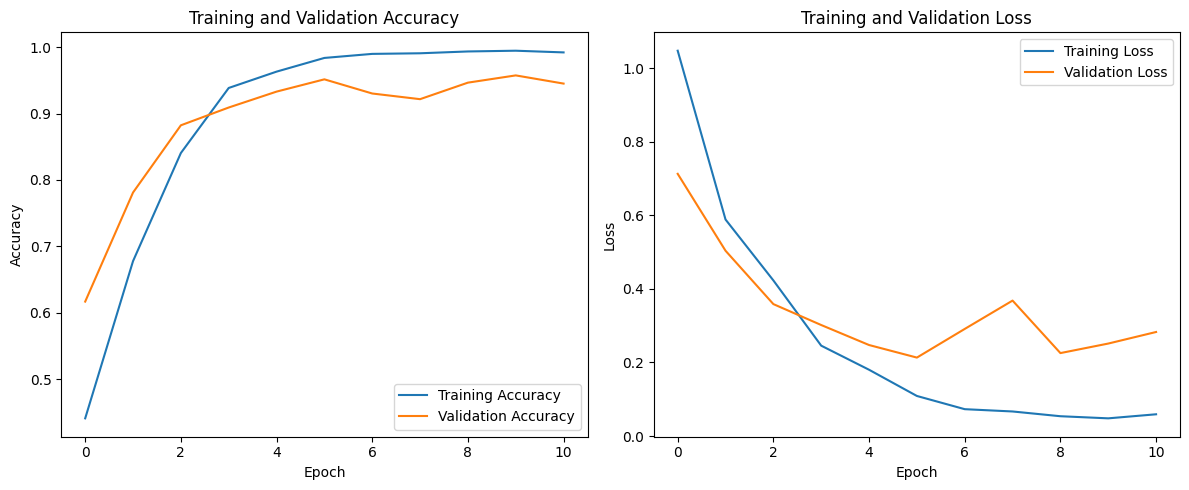

In [47]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


AttributeError: module 'pydot' has no attribute 'InvocationException'

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import load_model

# โหลดโมเดล LSTM ที่ดีที่สุด
best_model = load_model('../../models/LSTM_models_sample.keras')

In [30]:
df_balanced

,rating,location_id,review,cleaned_review,embedding,sentiment,location_id_numeric
0,3,4322585,This was an ornate wat inside Mae Sot. It is a...,ornate wat inside mae sot burmese style wat ty...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral,4322585
1,2,2667297,Got the Asia perfect for body treatment. We re...,got asia perfect body treatment read review th...,"[0.00053091, 0.15045358, 0.00889446, -0.038750...",negative,2667297
2,4,10388576,A few years ago a huge market was built in Ban...,year ago huge market built ban phe totally dis...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",positive,10388576
3,1,6885224,The visit to this island is worth it just to u...,visit island worth understand tragic result un...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,6885224
4,5,6669325,So many different bananas! And a chance to see...,many different banana chance see stored taste ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",positive,6669325
...,...,...,...,...,...,...,...
14062,3,7287889,It is not as pretty as some picture lead to be...,pretty picture lead believe big either minute ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral,7287889
14063,1,10631803,The whole trip was spoilt by lying local tour ...,whole trip spoilt lying local tour package sel...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,10631803
14064,3,1368429,"As a keen biker, I was excited to experience t...",keen biker excited experience breathtaking sce...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral,1368429
14065,5,8300428,This place is really beautiful and was decorat...,place really beautiful decorated statue mae na...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",positive,8300428


In [27]:
df_balanced['embedding'][0]

'[[ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n ...\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [-0.00701559  0.28866604  0.02099591 ... -0.07148592  0.21406499\n  -0.04538575]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]]'

In [28]:
def convert_embedding(embedding):
    # If the embedding is already a numpy array, return it as is
    if isinstance(embedding, np.ndarray):
        return embedding.flatten()  # Flatten if it's a 2D numpy array
    
    # If the embedding is a string, clean and parse it
    if isinstance(embedding, str):
        # Clean up the embedding string: replace newlines and ensure proper spacing
        embedding = embedding.replace("\n", " ").replace("...", "")
        # Remove extra spaces and brackets for easier parsing
        embedding = embedding.replace("[", "").replace("]", "").strip()
        
        try:
            # Split the cleaned string by spaces and convert it to a list of floats
            embedding_list = [float(val) for val in embedding.split()]
            # Convert the list into a numpy array
            embedding_array = np.array(embedding_list)
            
            # Flatten if it's a 2D array (e.g., matrix)
            return embedding_array.flatten()
        
        except ValueError:
            print(f"Error parsing embedding: {embedding}")
            # Return a zero-vector if there's an issue with parsing
            return np.zeros(300)  # Adjust size as needed
    
    # If it's neither a string nor a numpy array, return a default zero vector
    print(f"Unexpected data type: {type(embedding)}")
    return np.zeros(300)  # Adjust size as needed

In [29]:
df_balanced['embedding'] = df_balanced['embedding'].apply(convert_embedding)

In [32]:
validate_review_df = df_balanced

In [33]:
validate_review_df.sort_values(by='sentiment', ascending=True).head(10)

,rating,location_id,review,cleaned_review,embedding,sentiment,location_id_numeric
7033,1,8146452,A deep drive inland from rayong town. But a pi...,deep drive inland rayong town pity fruit orcha...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,8146452
9866,2,6669305,"When people think of ""national parks"" they nor...",people think national park normally except som...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,6669305
9867,1,4340403,All the negative reviews are true! constant ha...,negative review true constant hassle buy drink...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,4340403
9870,1,17642639,Terrible place !! Very bad customer service!! ...,terrible place bad customer service girl rude ...,"[0.00044389, 0.02045423, 0.00404787, -0.008911...",negative,17642639
9871,1,1887234,Definitely prefer the Andaman Wave Master. In ...,definitely prefer andaman wave master phi phi ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.00456293, 0....",negative,1887234
4206,1,7715997,We went there for 2 times this trip. All offic...,went time trip official time said close pm inc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,7715997
4205,2,456466,There was nothing to do much. The water fall w...,nothing much water fall like almost dry water ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,456466
9872,2,6668965,"Haven't heard of the ""famous"" Phra Buddha Maha...",heard famous phra buddha maha thammaraja statu...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,6668965
4203,2,9710056,This will bring you to the viewpoint of the Ba...,bring viewpoint bang pra reservoir view ok far...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,9710056
9875,1,455812,It was a really sad experience. This place abu...,really sad experience place abuse animal peopl...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",negative,455812


In [34]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(validate_review_df['cleaned_review'])

X_val_resampled = tokenizer.texts_to_sequences(validate_review_df['cleaned_review'])
X_val_resampled = pad_sequences(X_val_resampled, maxlen=max_sequence_length)

y_val_resampled = validate_review_df['sentiment'].map(label_mapping)

In [35]:
y_val_resampled.shape

(14067,)

In [36]:
X_val_resampled.shape

(14067, 300)

In [37]:
# ใช้โมเดล LSTM ทำนายข้อมูล validation set
lstm_preds = best_model.predict(X_val_resampled)
lstm_preds = np.argmax(lstm_preds, axis=1)

# ฝึก Gradient Boosting Classifier บนผลลัพธ์จาก LSTM
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(lstm_preds.reshape(-1, 1), y_val_resampled)

# # ทำนายผลลัพธ์ด้วย Gradient Boosting
ensemble_preds = gb_clf.predict(lstm_preds.reshape(-1, 1))

# ตรวจสอบผลลัพธ์
print(classification_report(y_val_resampled, ensemble_preds))
print(confusion_matrix(y_val_resampled, ensemble_preds))

440/440 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4689
           1       0.96      0.99      0.97      4689
           2       0.99      0.96      0.97      4689

    accuracy                           0.98     14067
   macro avg       0.98      0.98      0.98     14067
weighted avg       0.98      0.98      0.98     14067

[[4665   24    0]
 [   3 4652   34]
 [  18  182 4489]]


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_val_resampled, lstm_preds, average='weighted')
recall = recall_score(y_val_resampled, lstm_preds, average='weighted')
f1 = f1_score(y_val_resampled, lstm_preds, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9819
Recall: 0.9814
F1-Score: 0.9814


In [43]:
# สร้างโมเดล Random Forest (Bagging)
from sklearn.linear_model import LogisticRegression


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_predictions = rf_model.predict(X_val)

# สร้างโมเดล Gradient Boosting (Boosting)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
gb_predictions = gb_model.predict(X_val)

lg_model = LogisticRegression(random_state=42)
lg_model.fit(X_train_resampled, y_train_resampled)
lg_predictions = lg_model.predict(X_val)

# วัดผลลัพธ์ของแต่ละโมเดล
print("Random Forest Accuracy:", accuracy_score(y_val, rf_predictions))
print("Gradient Boosting Accuracy:", accuracy_score(y_val, gb_predictions))
print("Logistic Regression Accuracy:", accuracy_score(y_val, lg_predictions))

Random Forest Accuracy: 0.9907604832977968
Gradient Boosting Accuracy: 0.7898602226960436
Logistic Regression Accuracy: 0.3842691305377873


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
# Ensemble วิธี Voting (Hard Voting)
from sklearn.ensemble import VotingClassifier

# รวมโมเดลทั้งสองด้วยการ Voting
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model), ('gb', gb_model), ('lg', lg_model)],
    voting='soft')

voting_model.fit(X_train_resampled, y_train_resampled)
voting_predictions = voting_model.predict(X_val)

# วัดผลลัพธ์จากการใช้ Voting
print("Voting Ensemble Accuracy:", accuracy_score(y_val, voting_predictions))

Voting Ensemble Accuracy: 0.9599620942904525


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
conf_matrix = confusion_matrix(y_val, voting_predictions)
print("Voting Ensemble Accuracy:", accuracy_score(y_val, voting_predictions))
print(classification_report(y_val, voting_predictions))

Voting Ensemble Accuracy: 0.9599620942904525
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1453
           1       0.94      0.98      0.96      1374
           2       0.98      0.90      0.94      1394

    accuracy                           0.96      4221
   macro avg       0.96      0.96      0.96      4221
weighted avg       0.96      0.96      0.96      4221



In [149]:
common_indices = y_val.index.intersection(review_df.index)
missing_indices = y_val.index.difference(review_df.index)
print(f"Common indices count: {len(common_indices)}")
print(f"Missing indices count: {len(missing_indices)}")

Common indices count: 1761
Missing indices count: 7239


In [150]:
predict_label = y_val_resampled

In [ ]:
# X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
lstm_preds = best_model.predict(X_val)
lstm_preds = np.argmax(lstm_preds, axis=1)

conf_matrix = confusion_matrix(y_val, lstm_preds)

print("Accuracy:", accuracy_score(y_val, lstm_preds))
print(classification_report(y_val, lstm_preds))
print(conf_matrix)

132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step
Accuracy: 0.9514333096422649
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1453
           1       0.89      0.99      0.93      1374
           2       0.99      0.87      0.93      1394

    accuracy                           0.95      4221
   macro avg       0.95      0.95      0.95      4221
weighted avg       0.96      0.95      0.95      4221

[[1443   10    0]
 [   1 1358   15]
 [  16  163 1215]]


In [66]:
import plotly.graph_objects as go

class_names = ['Negative', 'Natural', 'Positive']

fig = go.Figure(data=go.Heatmap(
        z=conf_matrix,
        x=[f'Predicted {label}' for label in class_names],  # predicted labels
        y=[f'Actual {label}' for label in class_names],  # actual labels
        hoverongaps=False,
        colorscale='Blues'  # Customize colorscale as needed
    ))

# Update layout for better readability
fig.update_layout(
    title='Confusion Matrix for 3 Classes',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    font=dict(size=14)
)

# Show the plot
fig.show()

In [67]:
redicted_df = pd.DataFrame({'predicted': lstm_preds}, index=y_val.index)
    
    # Concatenate y_val and the new predicted_df to create a new DataFrame
predict_df = pd.concat([y_val, redicted_df], axis=1)

In [68]:
predict_df

,sentiment,predicted
5688,1,1
12728,1,1
4096,2,2
10216,1,1
2848,1,1
...,...,...
6870,1,1
6933,1,1
5664,1,1
973,1,1


In [54]:
valid_y_val = predict_df.loc[predict_df.index.isin(review_df.index)]

# Now you can safely use .loc with valid_y_val indices
filtered_reviews = review_df.loc[valid_y_val.index]

In [55]:
filtered_reviews

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review
5688,0,15709019,842778540,"Had my 50th birthday here, paid for a VIP area...",50th Birthday Night Out,Friends getaway,5,Sugar Club Phuket,Samut Prakan,P03018341,joy,<OOV> <OOV> 50th birthday <OOV> paid <OOV> <OO...
4096,2,7797850,778052913,There are so many things to see her. Although ...,"Modern, fun and interesting",NONE,5,Wat Pahuaylad Temple,Phetchabun,P03014669,joy,<OOV> <OOV> <OOV> many things <OOV> see <OOV> ...
2848,6,3646467,946794528,This is the first place for me to actually vis...,The Wat I visited first and the first Thai wor...,Solo travel,5,Wat Pathum Wanaram,Nakhon Nayok,P03011368,joy,<OOV> <OOV> <OOV> first place <OOV> <OOV> <OOV...
4843,2,4743290,721908990,I took a tuk tuk from hotel near Railway Stati...,Worth a Look,NONE,3,City Pillar Shrine (Udon Thani),Bangkok,P03013204,joy,<OOV> took <OOV> tuk tuk <OOV> hotel near rail...
4653,2,669532,923163471,The animals are in tiny enclosures. \nGolf car...,Don’t go,Family,1,Khao Kheow Open Zoo,Bangkok,P03013450,joy,<OOV> animals <OOV> <OOV> tiny enclosures golf...
...,...,...,...,...,...,...,...,...,...,...,...,...
5328,0,456166,638095869,It looks like many Thai are motivated to do sp...,Like a pleasant garden,Solo travel,4,Romaneenart Park,Bangkok,P03013454,joy,<OOV> looks like many thai <OOV> motivated <OO...
5304,0,1639475,946727651,This museum showcased the history and culture ...,Interesting to learn about the history and cul...,Couples,5,Chiang Mai City Arts and Cultural Centre,Bangkok,P03013459,joy,<OOV> museum showcased <OOV> history <OOV> cul...
5397,0,4322638,723387240,Whilst the Chedi itself is am impressive struc...,Getting here is what makes it most interesting,Couples,4,Phra Samut Chedi,Samut Prakan,P03013499,joy,whilst <OOV> chedi <OOV> <OOV> <OOV> impressiv...
5664,0,14170166,883289021,Pirate tour\n\nMy husband booked this tour bef...,Great snorkelling experience,NONE,4,Phi Phi Island Boat Tours,Samut Prakan,P03018472,anger,pirate tour <OOV> husband booked <OOV> tour <O...


In [56]:

predictions_df = pd.DataFrame({
    'location_id': filtered_reviews['location_id'],
    'location_name': filtered_reviews['location_name'],
    'trip_type': filtered_reviews['trip_type'],
    'rating': filtered_reviews['rating'],
    'helpful_voting': filtered_reviews['helpful_votes'],
    'review_text': filtered_reviews['review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': predict_df['sentiment'],  # The actual sentiment labels
    'predicted_sentiment': predict_df['predicted'], # The predicted sentiment labels
    'place_id': filtered_reviews['place_id'],
    'place_name': filtered_reviews['province'],
    'emotion': filtered_reviews['emotion'],
    'review_id': filtered_reviews['review_id']
})

# predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
# predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.tail(5)


,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id
14049,NaN,NaN,NaN,NaN,NaN,NaN,2,0,NaN,NaN,NaN,NaN
14053,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
14057,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN
14065,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN
14066,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN


In [57]:
df_filtered = predictions_df.dropna()
df_filtered

,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id
0,2209612.0,Wat Ratchabophit,Family,5.0,0.0,Besides elegant grand palace and wat pra kaew ...,1,1,P03013220,Bangkok,joy,953596359.0
3,2209612.0,Wat Ratchabophit,Couples,5.0,0.0,Wat Ratchabophit is a Buddhist temple located ...,0,0,P03013220,Bangkok,joy,885904967.0
8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,0,0,P03013220,Bangkok,love,738692369.0
14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",2,2,P03013220,Bangkok,surprise,962482865.0
15,317504.0,Temple Of Dawn (Wat Arun),Couples,5.0,0.0,Probably the best temple in Bangkok.. given th...,0,0,P03013220,Bangkok,joy,962528316.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5900,7726805.0,Wat Prasat Temple,NONE,4.0,11.0,The size is not big. Pillars are well decorate...,2,2,P03013503,Nonthaburi,joy,877979960.0
5902,7726805.0,Wat Prasat Temple,Solo travel,5.0,1.0,Compared to the other temples in the local are...,2,2,P03013503,Nonthaburi,joy,658165922.0
5903,7726805.0,Wat Prasat Temple,Couples,4.0,0.0,Beautiful Lanna architecture and sacred Buddha...,1,1,P03013503,Nonthaburi,joy,591689577.0
5905,1831068.0,Prasat Puay Noi,NONE,3.0,4.0,Prasat Pueai Noi is claimed to be the biggest ...,1,1,P03013503,Nonthaburi,joy,752115552.0


In [58]:
df_filtered.to_csv('./output/LSTM_predictions.csv')

In [1]:
y_val = y_val.astype(int)
ensemble_preds_class = df_filtered.astype(int)


NameError: name 'y_val' is not defined

In [51]:
print(y_val.shape)            # Shape of y_val
print(ensemble_preds.shape) 

(1723,)
(1723,)


In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume y_test contains true class labels, and y_pred_prob contains predicted probabilities

# Binarize the output labels for calculating AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2

# Calculate the AUC for each class
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average='micro', multi_class='ovr')

print(f'Macro-Averaged AUC: {auc_macro:.4f}')
print(f'Micro-Averaged AUC: {auc_micro:.4f}')

NameError: name 'y_test' is not defined

In [165]:
from sklearn.metrics import log_loss

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 0.7264
